# SBTi Temperature Alignment tool examples
This notebook provides some examples on how to use the SBTi Temperature Alignment tool.

### Install the SBTi Python module
This is only required if you didn't already instally the module.

In [ ]:
!pip install SBTi

In [1]:
%matplotlib inline
import SBTi
from SBTi.data.excel import ExcelProvider
from SBTi.portfolio_aggregation import PortfolioAggregationMethod
from SBTi.portfolio_coverage_tvp import PortfolioCoverageTVP
from SBTi.temperature_score import TemperatureScore, Scenario, ScenarioType, EngagementType
from SBTi.target_validation import TargetProtocol
from SBTi.interfaces import ETimeFrames, EScope
import pandas as pd
import matplotlib.pyplot as plt
from examples.utils import collect_company_contributions, plot_grouped_statistics, anonymize, print_aggregations

### Download the dummy data provider

In [2]:
import urllib.request
import os

if not os.path.isdir("data"):
    os.mkdir("data")
if not os.path.isfile("data/data_provider_example.xlsx"):
    urllib.request.urlretrieve("https://github.com/OFBDABV/SBTi/raw/master/examples/data/data_provider_example.xlsx", "data/data_provider_example.xlsx")
if not os.path.isfile("example_portfolio.csv"):
    urllib.request.urlretrieve("https://github.com/OFBDABV/SBTi/raw/master/examples/example_portfolio.csv", "example_portfolio.csv")

#### Logging
The SBTi module uses the Python standard library logging utilities to send log messages. The log level can be changed according to the user's needs.

In [3]:
import logging
root_logger = logging.getLogger()
root_logger.setLevel("INFO")

### Create a data provider
Data providers let you connect to the data source of your choice.

In [4]:
provider = ExcelProvider(path="data/data_provider_example.xlsx")

### Load your portfolio
In our case the portfolio is stored as a CSV file. The portfolio should at least have an "id" (the identifier of the company) and a "proportion" (the weight of the company in your portfolio e.g. the value of the shares you hold) column.

In [5]:
portfolio = pd.read_csv("example_portfolio.csv", encoding="iso-8859-1")

In [6]:
portfolio.head(5)

,company_name,company_id,ISIN,weights,investment_value,engagement_target
0,"Advanced Micro Devices, Inc",US0079031078,US0079031078,6.36%,35000000,1.0
1,Adobe Systems Inc.,US00724F1012,US00724F1012,1.82%,10000000,NaN
2,Capgemini Group,FR0000125338,FR0000125338,1.82%,10000000,NaN
3,"Cisco Systems, Inc.",US17275R1023,US17275R1023,1.82%,10000000,NaN
4,Coca-Cola HBC AG,CH0198251305,CH0198251305,1.82%,10000000,NaN


To load the data from the data provider, we have to pass a list of IPortfolioCompany instances.

In [7]:
companies = SBTi.utils.dataframe_to_portfolio(portfolio)

[{'company_name': 'Advanced Micro Devices, Inc', 'company_id': 'US0079031078', 'ISIN': 'US0079031078', 'weights': '6.36%', 'investment_value': 35000000, 'engagement_target': 1.0, 'company_isin': 'US0079031078'}, {'company_name': 'Adobe Systems Inc.', 'company_id': 'US00724F1012', 'ISIN': 'US00724F1012', 'weights': '1.82%', 'investment_value': 10000000, 'engagement_target': nan, 'company_isin': 'US00724F1012'}, {'company_name': 'Capgemini Group', 'company_id': 'FR0000125338', 'ISIN': 'FR0000125338', 'weights': '1.82%', 'investment_value': 10000000, 'engagement_target': nan, 'company_isin': 'FR0000125338'}, {'company_name': 'Cisco Systems, Inc.', 'company_id': 'US17275R1023', 'ISIN': 'US17275R1023', 'weights': '1.82%', 'investment_value': 10000000, 'engagement_target': nan, 'company_isin': 'US17275R1023'}, {'company_name': 'Coca-Cola HBC AG', 'company_id': 'CH0198251305', 'ISIN': 'CH0198251305', 'weights': '1.82%', 'investment_value': 10000000, 'engagement_target': nan, 'company_isin': '

### Calculate the temperature scores
In the amended portfolio you'll find your original portfolio, amended with the emissions and the temperature score.

The temperature scores can be computed for different scopes and different timeframes.
More information on scopes and timeframes can be found on the SBTi website.

The timeframe options are SHORT, MID and LONG and can be implemented through the ETimeFrames object as shown in the cell below.
The scope options are S1, S2, S1S2, S3 and S1S2S3 and can be implemented using the EScope object, also shown in the cell below.
It is also possible to compute temperature scores for mulitple timeframes and scopes at once.

In this example, we use the mid-term timeframe and the S1S2 scope.

In [9]:
time_frames = [ETimeFrames.MID]
scopes = [EScope.S1S2, EScope.S1S2S3]
temperature_score = TemperatureScore(
    time_frames=time_frames,
    scopes=scopes
)
amended_portfolio = temperature_score.calculate(data_providers=[provider], portfolio=companies)
amended_portfolio.head()

### Calculate the aggregated temperature score
Calculate an aggregated temperature score. This can be done using different aggregation methods:
- Weighted Average Temperature Score (WATS)
- Total emissions weighted temperature score (TETS)
- Market Owned emissions weighted temperature score (MOTS)
- Enterprise Owned emissions weighted temperature score (EOTS)
- Enterprise Value + Cash emissions weighted temperature score (ECOTS)
- Total Assets emissions weighted temperature score (AOTS)
- Revenue owned emissions weighted temperature score (ROTS)

Here we use the "Weighted Average Temperature Score". For more details, have a look at notebook 3 ("3_portfolio_aggregations.ipynb"). The temperature scores are calculated per time-frame/scope combination.

To change the aggregation method, replace the extension "WATS" in the first line of the next cell by the abbreviation of the desired aggregation method.

In [10]:
temperature_score.aggregation_method = PortfolioAggregationMethod.WATS
aggregated_portfolio = temperature_score.aggregate_scores(amended_portfolio)
print_aggregations(aggregated_portfolio)

mid - S1S2: 2.74 degrees Celcius
mid - S1S2S3: 2.96 degrees Celcius


### Grouping companies
The tool allows the computation of temperature scores for _groups_ of companies. In this example we group the scores by
sector and region, and leave the timeframe and scope unchanged. Any categorical variable in the
fundamental data provided by a data provider can be used as grouping variables.

In [13]:
temperature_score = TemperatureScore(
    time_frames=time_frames,
    scopes=scopes,
    grouping=['sector', 'region']
)
grouped_portfolio = temperature_score.calculate(data_providers=[provider], portfolio=companies)
grouped_aggregations = temperature_score.aggregate_scores(grouped_portfolio)

# plot_grouped_heatmap(grouped_aggregations)

### Portfolio coverage

Gives insights in the coverage of portfolio entities that have set GHG emissions reduction targets, STBi-validated or otherwise. Companies with SBTi status Approved have a score of 100%, all others have a score of 0%.

In [11]:
portfolio_coverage_tvp = PortfolioCoverageTVP()
coverage = portfolio_coverage_tvp.get_portfolio_coverage(amended_portfolio.copy(), PortfolioAggregationMethod.WATS)
print("Part of portfolio with climate targets is {c:.2f}%".format(c=coverage))

Part of portfolio with climate targets is 35.45%


## Analysis
In order to identify the companies that your portfolio would most benefit from engaging with, it is possible to find the biggest contributors to your portfolio's temperature score.
Contributions can be found on an individual company level, as well as contributions from companies grouped by one of their characteristics, e.g. sector or region.
You can group on any categorical variable you provide through your dataprovider.

For our analysis we select one timeframe (mid-range) and one scope (S1+S2) and group the outcomes on sector.

In [12]:
time_frames = [ETimeFrames.MID]
scopes = [EScope.S1S2]
grouping = ['sector']
analysis_parameters = (time_frames, scopes, grouping)

temperature_score = TemperatureScore(time_frames=time_frames,
                                     scopes=scopes,
                                     grouping=grouping)
amended_portfolio = temperature_score.calculate(data_providers=[provider], portfolio=companies)
aggregated_portfolio = temperature_score.aggregate_scores(amended_portfolio)
company_contributions = collect_company_contributions(aggregated_portfolio, amended_portfolio, analysis_parameters)

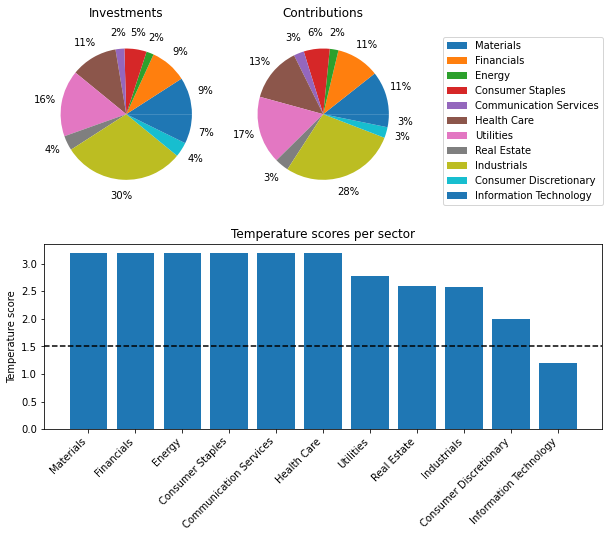

In [14]:
plot_grouped_statistics(aggregated_portfolio, company_contributions, analysis_parameters)

## Companies to engage
Besides statistics of the companies grouped by

In [15]:
company_contributions[['company_name', 'contribution', 'temperature_score', 'ownership_percentage', 'portfolio_percentage']][:10]

,company_name,contribution,temperature_score,ownership_percentage,portfolio_percentage
0,Company N,9.146808,3.20,0.189087,7.818182
1,"Advanced Micro Devices, Inc",4.257653,1.83,0.334454,6.363636
2,Company Q,2.552597,3.20,4.811121,2.181818
29,Dell Technologies,2.127165,3.20,0.290669,1.818182
22,Company AF,2.127165,3.20,0.974571,1.818182
23,Company F,2.127165,3.20,0.109647,1.818182
25,Capgemini Group,2.127165,3.20,0.323925,1.818182
26,Coca-Cola HBC AG,2.127165,3.20,0.049073,1.818182
27,CVS Health,2.127165,3.20,0.011175,1.818182
28,Danone,2.127165,3.20,12.247900,1.818182


### Scenarios
To determine the effect of engaging (part of) your portfolio, you can run a number of scenarios:
 - 1: Engage companies to set targets. This means that the default score (i.e. the score when a company didn't set a target) will be set to 2 degrees celcius.
 - 2: Engage companies to have their targets validated by the SBTi. This means that the maximum score for all targets will be capped at 1.75 degrees celcius.
 - 3a: engage the top 10 contributors to set targets. This means that their default score (i.e. the score when a company didn't set a target) will be set to 2 degrees celcius.
 - 3b: engage the top 10 contributors to have their targets validated by the SBTi. This means that the maximum score for all the targets of these companies will be capped at 1.75 degrees celcius.
 - 4a: engage the predefined companies to set targets. This means that their default score (i.e. the score when a company didn't set a target) will be set to 2 degrees celcius.
 - 4b: engage the predefined companies to have their targets validated by the SBTi. This means that the maximum score for all the targets of these companies will be capped at 1.75 degrees celcius.

In this example, we will investigate the effect of engaging Company Q in setting targets.

Define scenario (see notebook "2_scenarios.ipynb" for more information)

In [16]:
scenario = Scenario()
scenario.scenario_type = ScenarioType.HIGHEST_CONTRIBUTORS_APPROVED
scenario.engagement_type = EngagementType.SET_TARGETS
scenario.aggregation_method = PortfolioAggregationMethod.WATS
scenario.grouping = 'sector'

Add Company Q to the companies for which a target is set. Please note that this is in addition to the other predefined companies in the portfolio, which are marked for engagement.

In [17]:
scenario_portfolio = portfolio.copy()
scenario_portfolio.loc[scenario_portfolio['company_name'] == 'Company Q', 'engagement_target'] = 1.0

In [18]:
scenario_companies = [SBTi.interfaces.PortfolioCompany.parse_obj(company) for company in scenario_portfolio.to_dict(orient="records")]
scenario_data = SBTi.utils.get_data([provider], scenario_companies)

temperature_score.scenario = scenario
scenario_companies = SBTi.utils.dataframe_to_portfolio(scenario_portfolio)
scenario_scores = temperature_score.calculate(data_providers=[provider], portfolio=scenario_companies)
scenario_aggregated = temperature_score.aggregate_scores(scenario_scores)
print_aggregations(scenario_aggregated)

mid - S1S2: 1.84 degrees Celcius


# Sort barchart
# Plot hline

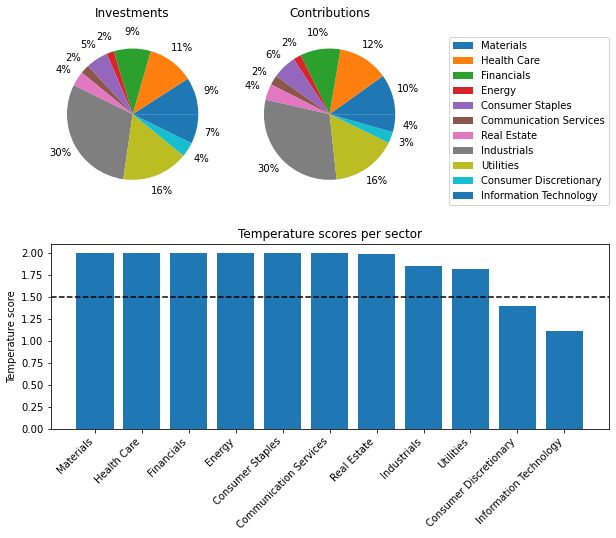

In [19]:
company_contributions = collect_company_contributions(scenario_aggregated, scenario_scores, analysis_parameters)
plot_grouped_statistics(scenario_aggregated, company_contributions, analysis_parameters)

In [19]:
company_contributions[['company_name', 'contribution', 'temperature_score', 'ownership_percentage', 'portfolio_percentage']][:10]

,company_name,contribution,temperature_score,ownership_percentage,portfolio_percentage
0,Company N,8.504326,2.00,0.189087,7.818182
1,"Advanced Micro Devices, Inc",6.333745,1.83,0.334454,6.363636
2,Company Q,2.373300,2.00,4.811121,2.181818
31,Delta Electronics,1.977750,2.00,0.014135,1.818182
23,Company AF,1.977750,2.00,0.974571,1.818182
25,Company E,1.977750,2.00,3.386608,1.818182
26,Capgemini Group,1.977750,2.00,0.323925,1.818182
27,Coca-Cola HBC AG,1.977750,2.00,0.049073,1.818182
28,CVS Health,1.977750,2.00,0.011175,1.818182
29,Danone,1.977750,2.00,12.247900,1.818182


### Save anonymized data for SBTi target validation
In order for the targets to be validated by SBTi, you can save your data locally. By running the anonymize function, you can replace company identifiers with meaningless substitutes.

In [23]:
portfolio, provider = anonymize(portfolio, provider)

In order to store the portfolio and provider data locally, two options apply.
If you use the SBTi tool from a docker container, for each of the following 3 cells:
- Run the cell
- Open an Excel file
- Right-click an Excel cell and click 'paste' or select an Excel cell and press Ctrl+v
- Save the Excel file

In [ ]:
portfolio.to_clipboard(excel=True, index=False)

In [ ]:
provider.data['fundamental_data'].to_clipboard(excel=True, index=False)

In [ ]:
provider.data['target_data'].to_clipboard(excel=True, index=False)

If you run the SBTi tool locally, you:
- Specify the directory and filenames in the cell below
- Run the cell below

# Remove directory and test in colab

In [ ]:
portfolio_filename = 'C://Users//username//Documents//portfolio.xlsx'
provider_filename = 'C://Users//username//Documents//provider.xlsx'
portfolio.to_excel(portfolio_filename, index=False)
provider.data['fundamental_data'].to_excel(provider_filename, sheet_name='fundamental_data', index=False)
provider.data['target_data'].to_excel(provider_filename, sheet_name='target_data', index=False)